In [12]:
%matplotlib inline

In [62]:
from typing import List, Union

from qiskit import pulse
from qiskit.pulse.reschedule import pad
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.pulse import Schedule, DriveChannel, MeasureChannel, FrameChange, Delay

import numpy as np

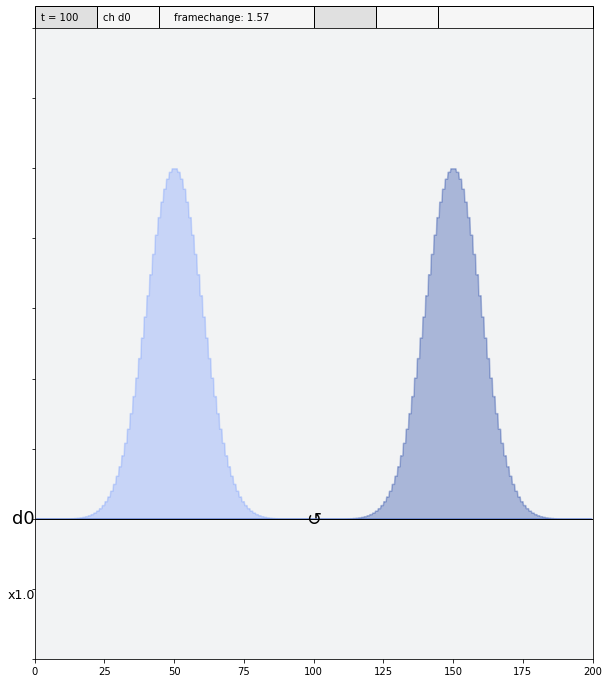

In [32]:
sched = Schedule()
f = pulse_lib.gaussian(100, 1.0, 10.0)
sched += f(DriveChannel(0))
sched += FrameChange(np.pi/2)(DriveChannel(0))
sched |= f(DriveChannel(0)).shift(100)
sched.draw()

In [132]:
ramsey = pulse.Schedule()
x90 = pulse_lib.gaussian_square(100, 0.5j, 50, 20)
ramsey += x90(DriveChannel(0))
ramsey += Delay(100)(DriveChannel(0))
ramsey += x90(DriveChannel(0))
align = [f(DriveChannel(0)), f(DriveChannel(0)), ramsey, f(DriveChannel(1))]

# Align left

In [144]:
def push_append(this: List[Union[pulse.Instruction, pulse.Schedule]], 
                other: List[Union[pulse.Instruction, pulse.Schedule]]) -> 'Schedule':
        r"""Return a new schedule with `schedule` inserted at the maximum time over
        all channels shared between `self` and `schedule`.

       $t = \textrm{max}({x.stop\_time |x \in self.channels \cap schedule.channels})$

        Args:
            schedule: schedule to be appended
            buffer: Whether to obey buffer when appending
            name: Name of the new schedule. Defaults to name of self
        """
        common_channels = set(this.channels) & set(other.channels)
        
        channels = {}
        stop_time = other.ch_stop_time(*channels)
        max_time_delta = 0
        min_start_time = this.duration
        for channel in common_channels:
            min_start_time = min(min_start_time, this.ch_start_time(channel))
        
        return other.insert(min_start_time, other)
    
def align_left(*instructions: List[Union[pulse.Instruction, pulse.Schedule]]):
    """Align a list of pulse instructions on the left
    
    Args:
        instructions: List of pulse instructions to align.
    
    Returns:
        pulse.Schedule
    """
    aligned = pulse.Schedule()
    for instruction in instructions:
        
        aligned = push_append(aligned, instruction)
    
    return aligned

In [145]:
aligned_left = align_left(*align)
aligned_left.draw()

PulseError: 'Schedules overlap: Overlap on channel DriveChannel(0) over time range [0, 100] for Schedule(name="p15", duration=100), Schedule(name="p15", duration=100)'

In [101]:
def align_right(*instructions: List[Union[pulse.Instruction, pulse.Schedule]]):
    """Align a list of pulse instructions on the right
    
    Args:
        instructions: List of pulse instructions to align.
    
    Returns:
        pulse.Schedule
    """
    aligned = pulse.Schedule()
    left_aligned = align_left(*instructions)
    max_duration = 0
    
    channel_durations = {}
    for channel in left_aligned.channels:
        channel_sched = left_aligned.filter(channels=[channel])
        channel_duration = channel_sched.duration
        channel_durations[channel] = channel_sched.duration
        max_duration = max(max_duration, channel_duration)
    
    for instr_time, instruction in left_aligned.instructions:
        instr_max_dur = max(channel_durations[channel] for channel in instruction.channels)
        instr_delayed_time = max_duration - instr_max_dur + instr_time
        aligned |= instruction.shift(instr_delayed_time)
        
    
    return aligned
    

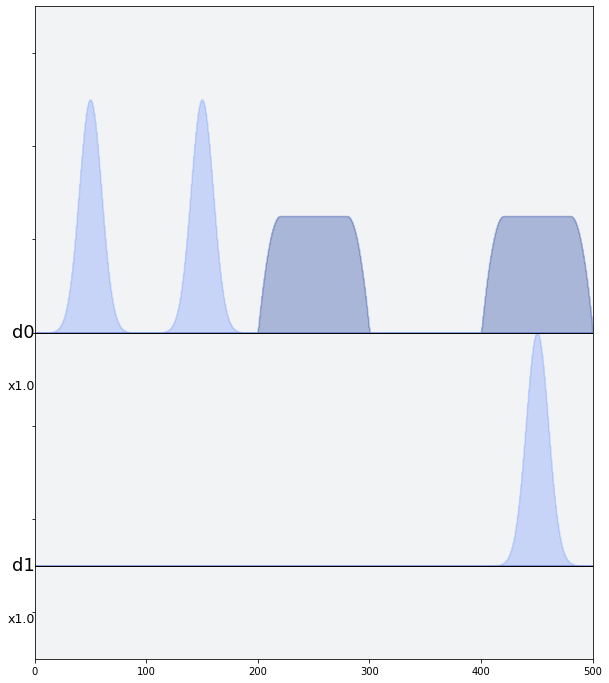

In [102]:
aligned_right = align_right(*align)
aligned_right.draw()

In [105]:
def align_left_padded(*instructions: List[Union[pulse.Instruction, pulse.Schedule]]):
    """Align a list of pulse instructions on the left with padding
    
    Args:
        instructions: List of pulse instructions to align.
    
    Returns:
        pulse.Schedule
    """
    aligned = align_left(*instructions)
    return pad(aligned)

def align_right_padded(*instructions: List[Union[pulse.Instruction, pulse.Schedule]]):
    """Align a list of pulse instructions on the right with padding
    
    Args:
        instructions: List of pulse instructions to align.
    
    Returns:
        pulse.Schedule
    """
    aligned = align_right(*instructions)
    return pad(aligned)

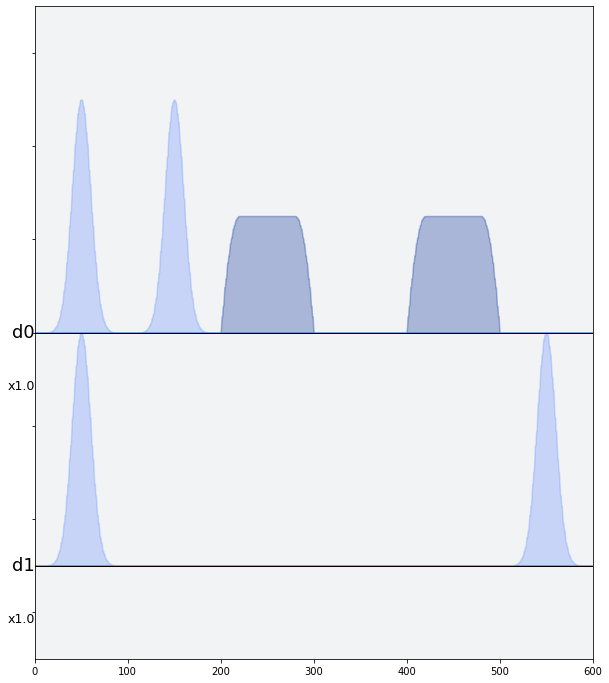

In [106]:
aligned_left_padded = align_left_padded(*align)
aligned_left_padded.draw()
added =  aligned_left_padded + f(DriveChannel(1))
added.draw()

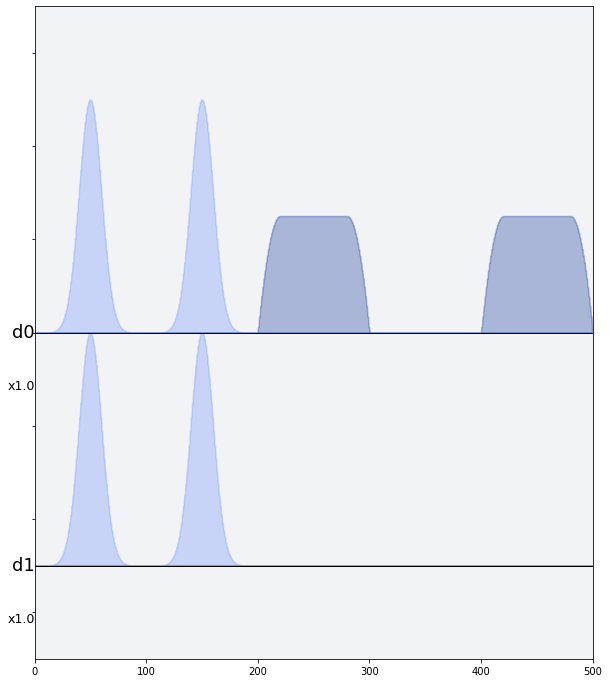

In [100]:
added =  aligned_left + f(DriveChannel(1))
added.draw()

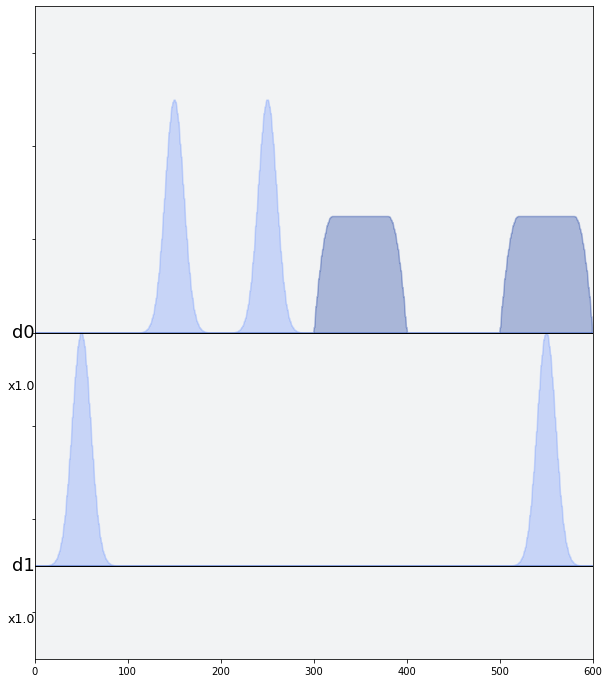

In [108]:
aligned_right_padded = align_right_padded(*align)
aligned_right_padded.draw()
added =  f(DriveChannel(1)) + aligned_right_padded 
added.draw()

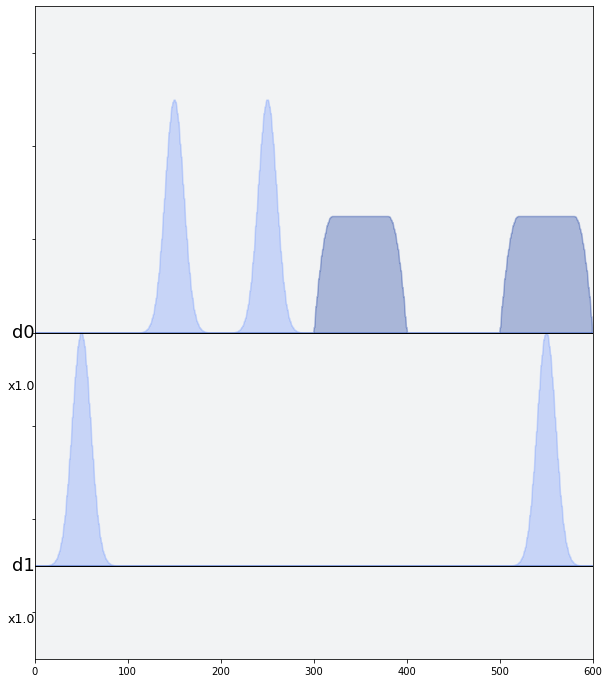

In [116]:
added =  align_left(f(DriveChannel(1)), aligned_right)
added.draw()

In [110]:
def align_in_sequence(*instructions: List[Union[pulse.Instruction, pulse.Schedule]]):
    """Align a list of pulse instructions in sequence
    Args:
        instructions: List of pulse instructions to align.
    Returns:
        pulse.Schedule
    """
    aligned = pulse.Schedule()
    for instruction in instructions:
        aligned |= instruction.shift(aligned.duration)
    return aligned

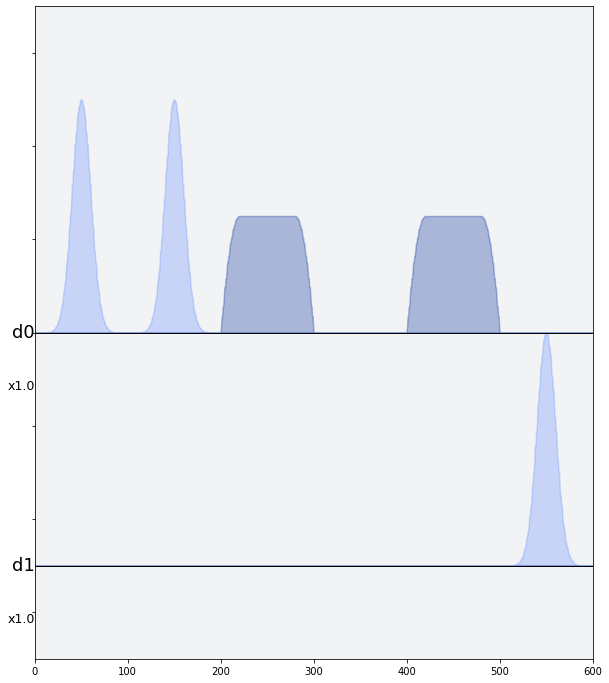

In [112]:
align_in_sequence(*align).draw()